## Class StreetMap

This class was designed to provide a way for users to query for streetmap data via the OpenStreetMap API, using the osmnx wrapper. It enables users to specify default values for speedlimit based on road type, as speed limit data is largely missing from OSM. Alternatively, default values are also provided.

### Class Source Code

In [26]:
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point


class StreetMap():
    # Fallback speedlimits per road type (in place of missing data)
    hwy_speeds = {
        'motorway': 70,
        'trunk': 65,
        'primary': 55,
        'secondary': 45,
        'tertiary': 35,
        'unclassified': 30,
        'residential': 25}
    
    fallback = 45 # Last resort

    
    def __init__(self, center, dist, crs='epsg:4326', hwy_speeds=hwy_speeds, fallback=fallback):
        '''
        This class was designed to provide a way for users to query for streetmap data via the 
        OpenStreetMap API, using the osmnx wrapper. It enables users to specify default values 
        for speedlimit based on road type, as speed limit data is largely missing from OSM. Alternatively, 
        default values are also provided.
        
        params: 
                center:        Tuple(Lon, Lat) coordinate points to act as centroid of street data
                dist:          Numeric distance (meters) from center to query street data for
                crs:           Defualt: 'epsg:4326'; Used for projection
                hwy_speeds:    Dict object containing {osm_road_type : fallback_speed_limit} 
                               for use in place of missing values
                fallback:      Master fallback that is used in place of anything unspecified for a missing value
                
        attributes: 
                centroid:        Returns Point object of provided center
                centroid_gdf:    Returns a projected GeoDataFrame of centroid
                gdf:             Returns the buffered polygon in a GeoDataFrame
                poly:            Returns the buffered polygon
                bounds:          Returns (minx, miny, maxx, maxy) bounds of poly
                G:               Returns Graph object containing street data within poly
                nodes:           Returns G nodes in GeoDataFrame
                edges:           Returns G edges in GeoDataFrame
        '''
        # Defines attributes for the center point
        self.centroid   = Point(center)
        self.centroid_gdf = gpd.GeoDataFrame([self.centroid], columns=['geometry'], crs=crs)
        
        # Defines the buffered/projected shape
        self.gdf = self.centroid_gdf.to_crs('+proj=aeqd +units=m  +x_0=0 +y_0=0')
        self.gdf = self.gdf['geometry'].buffer(dist).to_crs(crs)
        self.poly = self.gdf[0]
        
        # Defines attributes for the buffered shape boundaries
        self.bounds = self.gdf.bounds.values[0]
        
        # Queries for graph, travel speeds, bearing
        self.G = ox.graph_from_polygon(self.poly, network_type='drive_service')
        self.G = ox.speed.add_edge_speeds(self.G, hwy_speeds=hwy_speeds, fallback=fallback)
        self.G = ox.bearing.add_edge_bearings(self.G)
        
        # Converts graph to GeoDataFrames
        self.nodes, self.edges = ox.graph_to_gdfs(self.G, nodes=True, edges=True)

## Function generate

This function was designed specifically to be used alongside class StreetMap, though it does not need to be. The function takes in a graph and two kwargs with int values, instructing the function to generate n random points for housesor select n random nodes for gasstations. A nearest neighbor search is performed oneach house, and the resulting neighbors will represent the agent's target locations.

### Function Source Code

In [27]:
import numpy as np
import random
from shapely.geometry import MultiPoint
from shapely.geometry import LineString
from shapely.geometry import mapping


def generate(streetmap, houses=None, gasstations=None):
    '''
    This function was designed specifically to be used alongside class StreetMap, 
    though it does not need to be. The function takes in a graph and two kwargs 
    with int values, instructing the function to generate n random points for houses
    or select n random nodes for gasstations. A nearest neighbor search is performed on
    each house, and the resulting neighbors will represent the agent's target 
    locations.
    
    params:
        streetmap:      Graph object generated via class StreetMap
        houses:         Int value kwarg, how many random points to generate for houses
        gasstations:    Int value kwarg, how many nodes to select randomly from streetmap
        
    returns:
        objects:    Dict object with the following key, value pairs:
                    dict(
                        points      = MultiPoint object of n_houses random points, 
                        houses      = Array of Point objects for each neighbor, 
                        connections = Array of LineStrings connecting points to houses, 
                        gasstations = Array of Point objects for each gasstation, 
                        osmids      = dict(houses=Int64Index(houses_osmids), 
                                           gasstations=Int64Index(gasstations_osmids))
                    )
                    
        note that only objects.get('osmids') is needed by other classes. The other key, value pairs
        are present for visualizations only.
    '''
    # Collection of all objects
    objects = dict({
        'points':None,
        'houses':None,
        'connections':None,
        'gasstations':None,
        'osmids':dict()}) 
    
    # Collection of object IDs
    _osmids = dict()
    
    # Exterior bounds of streetmap
    minx, miny, maxx, maxy = streetmap.bounds
    
    
    # Generates random points within bounds of polygon
    def random_points(n):
        points = []
        while len(points) < n:  
            # generates random point within bounds max(x,y) to min(x,y)
            random_point = Point([random.uniform(minx, maxx), 
                                  random.uniform(miny, maxy)])

            # Verifies points within polygon and appends
            if (random_point.within(streetmap.gdf[0])):
                points.append(random_point)
        
        return points
    
    
    # Generates house points within polygon
    def _houses(n):
        # Creates seperate collections for coordinates
        points     = MultiPoint(random_points(n))
        coords     = np.array(mapping(points).get('coordinates'))
        longitudes = coords[:,0]
        latitudes  = coords[:,1]
        
        # Queries nearest node in polygon for each rand point
        destinations = ox.distance.nearest_nodes(streetmap.G, longitudes, latitudes) 
        houses       = streetmap.nodes.loc[destinations]['geometry']
        
        # Linestrings connecting random points to their associated house
        connections = list(LineString([point, house]) for point, house in zip(points.geoms, houses))
        
        # Updates objects variables
        objects.update({
            'points':points, 
            'houses':houses.to_numpy(), 
            'connections':connections})
        _osmids.update({
            'houses':houses.index})

    
    # Generates array of random nodes taken from street network
    def _gasstations(n):
        gasstations = streetmap.nodes.sample(n=n)['geometry'] # Samples dataframe
        
        # Updates objects variables
        objects.update({
            'gasstations':gasstations.to_numpy()})
        _osmids.update({
            'gasstations':gasstations.index}) 
    
    
    # Generates args as provided
    _houses(houses)
    _gasstations(gasstations)
    
    # Updates objects variables
    objects.update({
        'osmids':_osmids,})
    
    return objects

### Example Usage

##### Creating an instance

In [34]:
center = (-121.885254, 37.335796)
dist = 1000 # Meters

# Creates polygon with given dimensions
poly = StreetMap(center, dist)

##### Generating objects

In [35]:
n_houses = 60 # Houses
n_gasstations = 5 # Gas stations

# Instructs class to generate random coordinate points within polygon
objects = generate(streetmap=poly, houses=n_houses, gasstations=n_gasstations)

##### Querying for data

In [36]:
# This utilizes gpd.GeoDataFrame as a wrapper for matplotlib to simplify the visualizations
points = gpd.GeoDataFrame(objects.get('points'), columns=['geometry'])
houses = gpd.GeoDataFrame(objects.get('houses'), columns=['geometry'])
connections = gpd.GeoDataFrame(objects.get('connections'), columns=['geometry'])
gasstations = gpd.GeoDataFrame(objects.get('gasstations'), columns=['geometry'])

##### Visualizing the data

<AxesSubplot:>

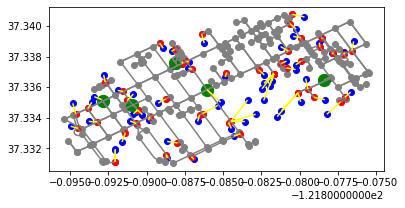

In [37]:
# Plots houses
ax = points.plot(color='blue')

# Plots street network
nodes, edges = poly.nodes, poly.edges
nodes.plot(ax=ax, color='grey')
edges.plot(ax=ax, color='grey')

# Plots nearest nodes to each house
houses.plot(ax=ax, color='red')

# Plots connections to visually represent neighbors
connections.plot(ax=ax, color='yellow')

# Plots gas stations
gasstations.plot(ax=ax, color='green', markersize=150)

##### Creating multiple object groups
for seperate episodes. Cell blocks are purposefully seperated below, as the second cell block is only necessary for visualization and therefore will not be used by an agent.

In [43]:
n_episodes = 10

episodes = dict()
for i in range(n_episodes):
    n_houses      = random.randint(10, 20)
    n_gasstations = random.randint(2, 5)
    objects       = generate(streetmap=poly, houses=n_houses, gasstations=n_gasstations)
    episodes.update({i:objects})

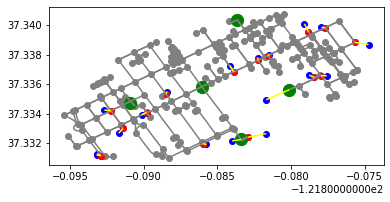

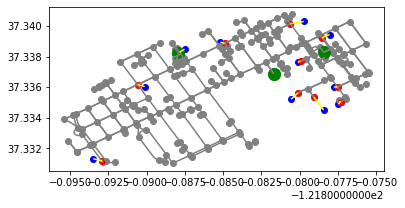

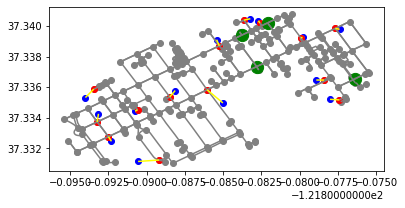

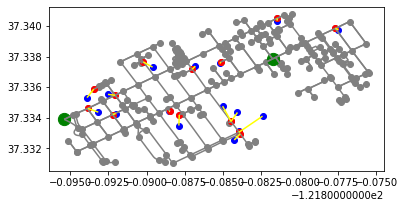

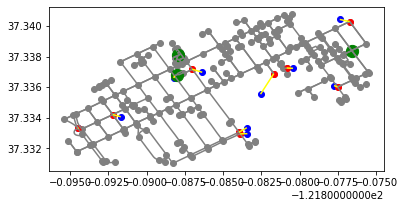

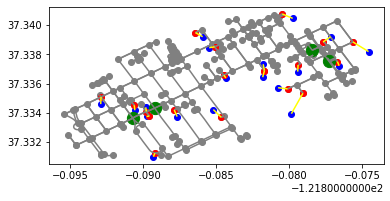

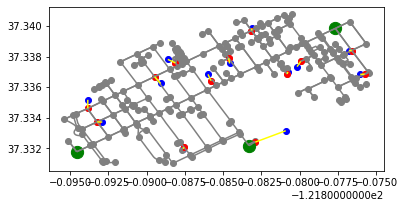

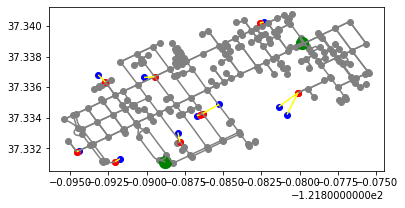

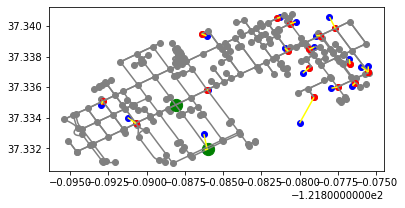

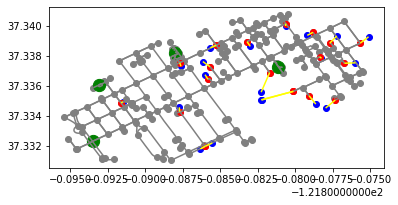

In [54]:
for _, episode in episodes.items():
    # This utilizes gpd.GeoDataFrame as a wrapper for matplotlib to simplify the visualizations
    points = gpd.GeoDataFrame(episode.get('points'), columns=['geometry'])
    houses = gpd.GeoDataFrame(episode.get('houses'), columns=['geometry'])
    connections = gpd.GeoDataFrame(episode.get('connections'), columns=['geometry'])
    gasstations = gpd.GeoDataFrame(episode.get('gasstations'), columns=['geometry'])

    # Plots houses
    ax = points.plot(color='blue')

    # Plots street network
    nodes, edges = poly.nodes, poly.edges
    nodes.plot(ax=ax, color='grey')
    edges.plot(ax=ax, color='grey')

    # Plots nearest nodes to each house
    houses.plot(ax=ax, color='red')

    # Plots connections to visually represent neighbors
    connections.plot(ax=ax, color='yellow')

    # Plots gas stations
    gasstations.plot(ax=ax, color='green', markersize=150)